# Assignment 4 - NLP Disaster Tweets Kaggle Mini Project

## Description

This project is a binary text classification. The goal of this project is to develop a recurring nueral network model that can accurately identify Tweets whose content relates to a real disaster from those that do not. The data is provided by the Kaggle Natural Language Processing with Disaster Tweets Competition and located at https://www.kaggle.com/c/nlp-getting-started/overview.


## Data Summary
The data consists of training and test data.  The train.csv file contains the training data comprised of an id, keyword, location, Tweet text and ground truth labels. There are 7613 rows in the training data.  The test.csv file contains the test data comprised of an id, keyword, location, Tweet text, however it does not include a label. There are 3263 rows in the test data. The sample_submission.csv contains the ids of the test Tweets and sampleground truth labels. The labeles are to be replaced with test results and submitted for assessment of the model.

In [16]:
!pip install pandas emoji
!pip install nltk

In [1]:
#Set Page Width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [25]:
#Load Required Resources

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import models
from tensorflow.python.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Embedding
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.layers import*

In [3]:
## Import Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv ")

print(train_df.head(), '\n')
print(train_df.info(), '\n')
print('Train Shape: ', train_df.shape, '\n')
print(test_df.head(), '\n')
print(test_df.info())
print('Test Shape: ', test_df.shape, '\n')

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

Train Shape:  (7613, 5) 

   id 

### EDA

EDA will be performed as follows:

    1. Remove unnecessary columns (keyword and location)
    2. Check for NaNs and Nulls in remaining columns
    3. Understand distributions of data sets
    4. Cleanse test strings
        - Remove Punctuation
        - Remove Stop Words
        - Remove Hyperlinks
        - Convert to all lower case
    
Columns keyword and location are irrelevent to the analysis and therefore removed from the data sets.

**Drop keyword and location**

In [4]:
# drop key and location 

train_df = train_df.drop(['keyword', 'location'], axis=1)
test_df = test_df.drop(['keyword', 'location'], axis=1)

print(train_df.head(), '\n')
print(test_df.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1 

   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


**Check for Nulls**

In [5]:
#Check for NaNs and Nulls
print('Train id NaNs / Null Count: ', train_df['id'].isna().sum(), '\n')
print('Test id NaNs / Null Count: ', train_df['id'].isna().sum(), '\n')
print('Train text NaNs / Null Count: ', train_df['text'].isna().sum(), '\n')
print('Train text NaNs / Null Count: ', train_df['text'].isna().sum(), '\n')

Train id NaNs / Null Count:  0 

Test id NaNs / Null Count:  0 

Train text NaNs / Null Count:  0 

Train text NaNs / Null Count:  0 



**Label Distributions**

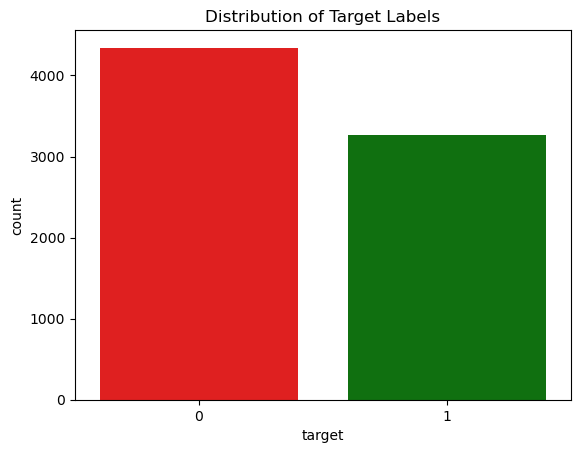

0 Label:  4342
1 Label:  3271


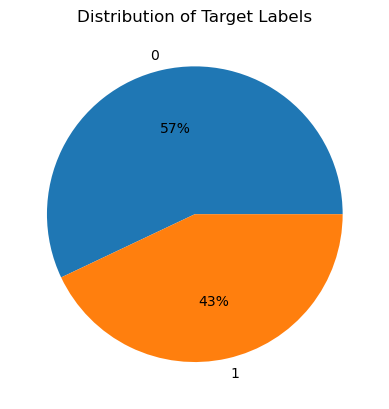

In [5]:
plt.figure()
sns.countplot(data=train_df, x='target', palette=['#ff0000',"#008000"])
plt.title('Distribution of Target Labels')
plt.show()

target_0 = train_df["target"].value_counts()[0]
target_1 = train_df["target"].value_counts()[1]
print('0 Label: ', target_0)
print('1 Label: ', target_1)

plt.figure()
plt.pie([target_0, target_1], labels=[0,1], autopct='%.0f%%')
plt.title('Distribution of Target Labels')
plt.show()


### Cleanse Data

**Remove Hyperlinks**

In [6]:
import re

print('Before')
print(train_df['text'][31])
print(test_df['text'][32])

train_df['text'] = train_df['text'].apply(lambda x:  re.sub(r'https?:\/\/\S+', '', x))
test_df['text'] = test_df['text'].apply(lambda x:  re.sub(r'https?:\/\/\S+', '', x))

print('After')
print(train_df['text'][31])
print(test_df['text'][32])


Before
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... http://t.co/kKFaSJv6Cj
After
@bbcmtd Wholesale Markets ablaze 
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... 


**Remove Punctuation**

In [7]:
train_df['text'] = train_df['text'].str.replace(r'[^\w\s]+', '')
test_df['text'] = test_df['text'].str.replace(r'[^\w\s]+', '')
print(train_df.head(), '/n')
print(test_df.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this earthquake Ma...       1
1   4              Forest fire near La Ronge Sask Canada       1
2   5  All residents asked to shelter in place are be...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  Just got sent this photo from Ruby Alaska as s...       1 /n
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about earthquake is different cities sta...
2   3  there is a forest fire at spot pond geese are ...
3   9              Apocalypse lighting Spokane wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


C:\Users\John.Stronks\AppData\Local\Temp\1\ipykernel_5172\2543514056.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['text'] = train_df['text'].str.replace(r'[^\w\s]+', '')
C:\Users\John.Stronks\AppData\Local\Temp\1\ipykernel_5172\2543514056.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text'] = test_df['text'].str.replace(r'[^\w\s]+', '')


**Remove Stop Words**

In [8]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
  
stop_words = stopwords.words('english')
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(train_df.head(), '/n')
print(test_df.head())


   id                                               text  target
0   1   Our Deeds Reason earthquake May ALLAH Forgive us       1
1   4              Forest fire near La Ronge Sask Canada       1
2   5  All residents asked shelter place notified off...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  Just got sent photo Ruby Alaska smoke wildfire...       1 /n
   id                                               text
0   0                   Just happened terrible car crash
1   2  Heard earthquake different cities stay safe ev...
2   3  forest fire spot pond geese fleeing across str...
3   9              Apocalypse lighting Spokane wildfires
4  11             Typhoon Soudelor kills 28 China Taiwan


**Convert to all lower case**

In [11]:
print('Before')
print(train_df['text'][31])
print(test_df['text'][32])

train_df['text'] = train_df['text'].apply(lambda x:  x.lower())
test_df['text'] = test_df['text'].apply(lambda x:  x.lower())

print('After')
print(train_df['text'][31])
print(test_df['text'][32])

Before
bbcmtd wholesale markets ablaze
3 car recorder zeroedgeå duallens car camera vehicle trafficdriving historyaccident camcorder large re
After
bbcmtd wholesale markets ablaze
3 car recorder zeroedgeå duallens car camera vehicle trafficdriving historyaccident camcorder large re


### Models

#### Simple LSTM Model

In [46]:
#Split the training data
x_training_set, x_validation_set, target_train, target_validation= train_test_split(train_df['text'].values, train_df['target'].values, random_state=25, test_size=0.3, shuffle=True)


max_length_text = train_df.text.map(len).max()
print('Maximum Text Length: ', max_length_text)
dict_size = 15000
embedding_size = 64
#Set Up tokenizer

tokenizer = text.Tokenizer(num_words = dict_size)
tokenizer.fit_on_texts(x_training_set)

word_index = tokenizer.word_index

sequence_x_training_set = tokenizer.texts_to_sequences(x_training_set)
sequence_x_validation_set = tokenizer.texts_to_sequences(x_validation_set)
sequence_x_test_set = tokenizer.texts_to_sequences(test_df['text'].values)

sequence_x_training_set_padded = sequence.pad_sequences(sequence_x_training_set, maxlen=max_length_text)
sequence_x_validation_set_padded = sequence.pad_sequences(sequence_x_validation_set, maxlen=max_length_text)
sequence_x_test_set_padded = sequence.pad_sequences(sequence_x_test_set, maxlen=max_length_text)

print('Training Shape: ', sequence_x_training_set_padded.shape)
print('Sample: ', sequence_x_training_set_padded[0])

#Hyperparameter Tuning variables
dropout_rate = .2
recurrent_dropout_rate = .2
num_epochs = 10

model = Sequential()

model.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
model.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model.add(Dense(embedding_size, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

input_shape = sequence_x_training_set_padded.shape  
model.build(input_shape) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)

Maximum Text Length:  139
Training Shape:  (5329, 139)
Sample:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 3519 1057 5398  968  969  239  373 3520 2660]
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_110 (ModuleWr (5329, 139, 64)           960000    
_________

#### Complex LSTM Model
Increase the complexity of the previous model by adding a Spatial Dropout layer and a Dropout layer around the LSTM layer

In [47]:
model_complex = Sequential()

model_complex.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
model_complex.add(SpatialDropout1D(0.5))  ## addtional layer
model_complex.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model_complex.add(Dropout(0.2)) ## addtional layer
model_complex.add(Dense(embedding_size, activation='relu'))
model_complex.add(Dense(1))
model_complex.add(Activation('sigmoid'))

input_shape = sequence_x_training_set_padded.shape  
model.build(input_shape) 

model.summary()

model_complex.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

comlex_history = model_complex.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_110 (ModuleWr (None, 139, 64)           960000    
_________________________________________________________________
module_wrapper_111 (ModuleWr (None, 128)               66048     
_________________________________________________________________
module_wrapper_112 (ModuleWr (None, 64)                8256      
_________________________________________________________________
module_wrapper_113 (ModuleWr (None, 1)                 65        
_________________________________________________________________
module_wrapper_114 (ModuleWr (None, 1)                 0         
Total params: 1,034,369
Trainable params: 1,034,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
167/167 - 46s - loss: 0.6139 - accuracy: 0.6489 - val_loss: 0.3680 - val_accuracy: 0.8593
Epoch 2/

### Model Comparison

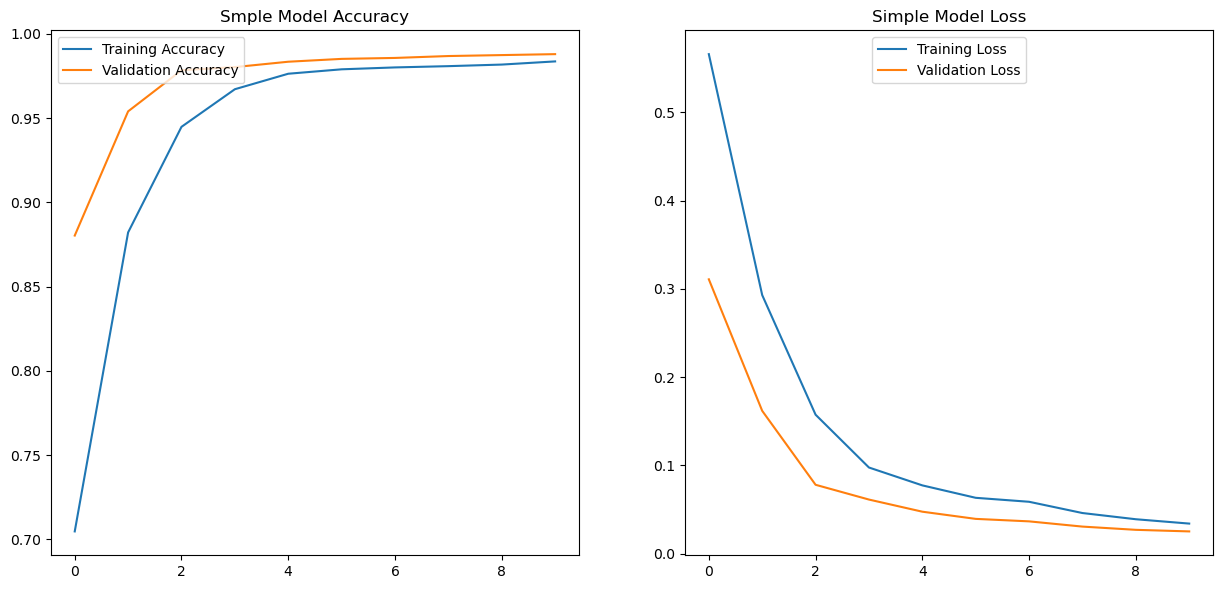

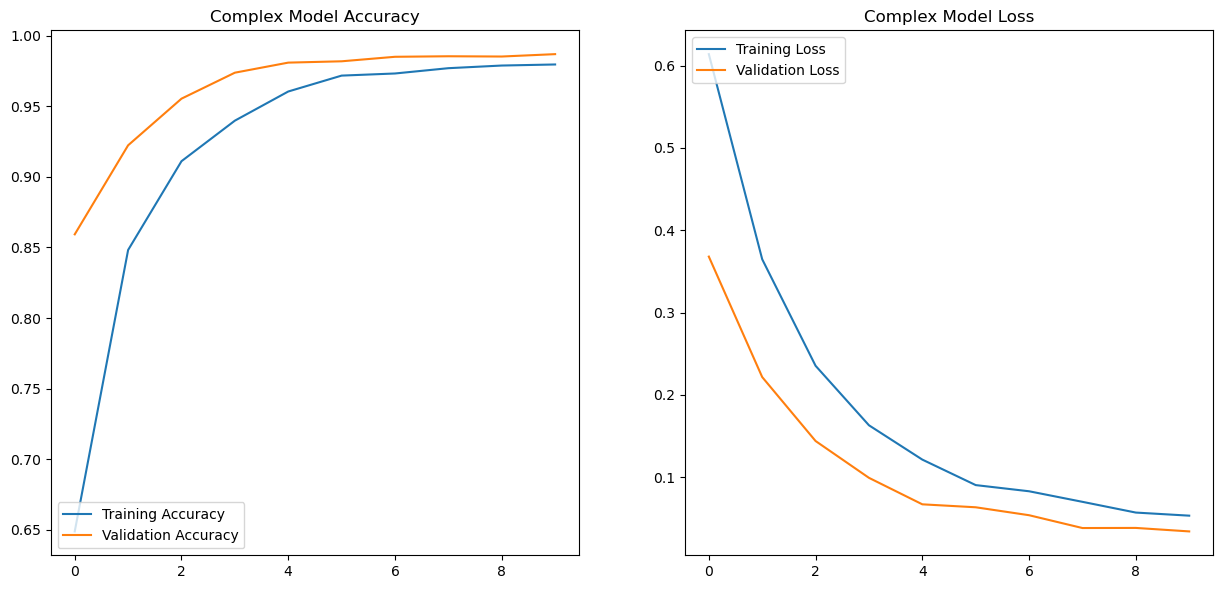

In [53]:
#Simple Model
model_accuracy = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
model_loss = history.history['loss']
model_val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, model_accuracy, label='Training Accuracy')
plt.plot(epochs_range, model_val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Smple Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, model_loss, label='Training Loss')
plt.plot(epochs_range, model_val_loss, label='Validation Loss')
plt.legend(loc='upper center')
plt.title('Simple Model Loss')
plt.show()

#complex Model
model_complex_accuracy = comlex_history.history['accuracy']
model_complex_val_acc = comlex_history.history['val_accuracy']
model_complex_loss = comlex_history.history['loss']
model_complex_val_loss = comlex_history.history['val_loss']


plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, model_complex_accuracy, label='Training Accuracy')
plt.plot(epochs_range, model_complex_val_acc, label='Validation Accuracy')
plt.legend(loc='lower left')
plt.title('Complex Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, model_complex_loss, label='Training Loss')
plt.plot(epochs_range, model_complex_val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Complex Model Loss')
plt.show()

### Hyperparameter Tuning

Number of Epochs and BiDirectional layer dropout rate will be varied and the impact on accruacy assessed.

In [58]:
epoch_count = [5, 10, 15, 20]
history = []

for e in epoch_count:

    num_epochs = e
    
    tune_model = Sequential()

    tune_model.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
    tune_model.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    tune_model.add(Dense(embedding_size, activation='relu'))
    tune_model.add(Dense(1))
    tune_model.add(Activation('sigmoid'))

    input_shape = sequence_x_training_set_padded.shape  
    tune_model.build(input_shape) 

    tune_model.summary()
    
    tune_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    tune_history = tune_model.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)

    print('Eochs: ', e)
    print('History: ', tune_history.history)
    history.append(tune_history.history)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_132 (ModuleWr (5329, 139, 64)           960000    
_________________________________________________________________
module_wrapper_133 (ModuleWr (5329, 128)               66048     
_________________________________________________________________
module_wrapper_134 (ModuleWr (5329, 64)                8256      
_________________________________________________________________
module_wrapper_135 (ModuleWr (5329, 1)                 65        
_________________________________________________________________
module_wrapper_136 (ModuleWr (5329, 1)                 0         
Total params: 1,034,369
Trainable params: 1,034,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
167/167 - 34s - loss: 0.5614 - accuracy: 0.7013 - val_loss: 0.3061 - val_accuracy: 0.8790
Epoch 2/5

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_147 (ModuleWr (5329, 139, 64)           960000    
_________________________________________________________________
module_wrapper_148 (ModuleWr (5329, 128)               66048     
_________________________________________________________________
module_wrapper_149 (ModuleWr (5329, 64)                8256      
_________________________________________________________________
module_wrapper_150 (ModuleWr (5329, 1)                 65        
_________________________________________________________________
module_wrapper_151 (ModuleWr (5329, 1)                 0         
Total params: 1,034,369
Trainable params: 1,034,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
167/167 - 54s - loss: 0.5591 - accuracy: 0.7050 - val_loss: 0.3000 - val_accuracy: 0.8801
Epoch 2/

### Hyperparameter Tuning Results

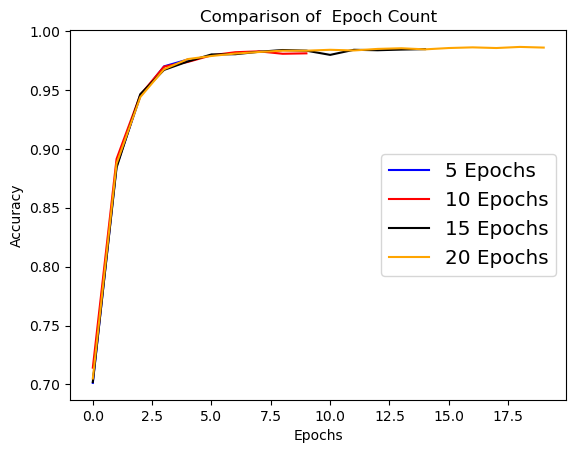

In [68]:

e1 = [11, 10, 12, 14, 16, 19, 17, 14, 18, 17]
x_e1 = range(0,5)
x_e2 = range(0,10)
x_e3 = range(0,15)
x_e4 = range(0,20)

fig, ax = plt.subplots()
ax.plot(x_e1, history[0]['accuracy'], label='5 Epochs', color='blue')
ax.plot(x_e2, history[1]['accuracy'], label='10 Epochs', color = 'red')
ax.plot(x_e3, history[2]['accuracy'], label='15 Epochs', color='black')
ax.plot(x_e4, history[3]['accuracy'], label='20 Epochs', color = 'orange')

legend = ax.legend(loc='center right', fontsize='x-large')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of  Epoch Count')
plt.show()

#### Accuracy Comparison

|Epoch Count|Accuracy|Validation Accuracy|
|:----|:--------:|:--------:|
|5|.9758|.9844|
|10|.9810|.9865|
|15|.9846|.9884|
|20|.9859|.9882|

In [70]:
#Get test set predictions
target_test = model.predict(sequence_x_test_set_padded, verbose = 1)
target_test
print('Test Shape: ', target_test.shape, '\n')

102/102 [==============================] - 5s 46ms/step
Test Shape:  (3263, 1) 



In [71]:
#Generate submission file
test_submission = np.where(target_test <= 0.5, 0, 1)

final_submission = np.transpose(test_submission)[0]
final_submission = pd.DataFrame()
final_submission['id'] = test_df['id']
final_submission['target'] = test_submission
print(final_submission.head())

final_submission.to_csv('submission.csv', index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


### Conclusion

**Model Comparison**

**Hyper paramter Tuning**

**Test Submission**

### References

Remove Stop Words from Text in DataFrame Column, https://www.datasnips.com/58/remove-stop-words-from-text-in-dataframe-column/

How to Remove URLs from Text in Python, https://bobbyhadz.com/blog/python-remove-url-from-text